### Logistic Regression for Solving Classification Problems

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results

I'll try to train a _logistic regression_ model using the Rain in Australia dataset to predict whether or not it will rain at a location tomorrow, using today's data. This is a _binary classification_ problem.

Let's install the `scikit-learn` library which we'll use to train our model.

In [1]:
!pip install scikit-learn --upgrade --quiet

     |████████████████████████████████| 22.3MB 1.7MB/s 


## Downloading the Data

We'll use the `opendatasets` library to download the data from Kaggle directly within Jupyter. Let's install and import `opendatasets`.

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/jsphyg/weather-dataset-rattle-package'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: edvinpillai
Your Kaggle Key: ··········


100%|██████████| 3.83M/3.83M [00:00<00:00, 153MB/s]

Once the above command is executed, the dataset is downloaded and extracted to the the directory `weather-dataset-rattle-package`.

In [5]:
import os
data_dir = './weather-dataset-rattle-package'
os.listdir(data_dir)

['weatherAUS.csv']

In [6]:
train_csv = data_dir + '/weatherAUS.csv'

Let's load the data from `weatherAUS.csv` using Pandas.

In [7]:
!pip install pandas --quiet

In [8]:
import pandas as pd
raw_df = pd.read_csv(train_csv)
raw_df

Date Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
0       2008-12-01   Albury     13.4  ...     21.8         No            No
1       2008-12-02   Albury      7.4  ...     24.3         No            No
2       2008-12-03   Albury     12.9  ...     23.2         No            No
3       2008-12-04   Albury      9.2  ...     26.5         No            No
4       2008-12-05   Albury     17.5  ...     29.7         No            No
...            ...      ...      ...  ...      ...        ...           ...
145455  2017-06-21    Uluru      2.8  ...     22.4         No            No
145456  2017-06-22    Uluru      3.6  ...     24.5         No            No
145457  2017-06-23    Uluru      5.4  ...     26.1         No            No
145458  2017-06-24    Uluru      7.8  ...     26.0         No            No
145459  2017-06-25    Uluru     14.9  ...     20.9         No           NaN

[145460 rows x 23 columns]

The dataset contains over 145,000 rows and 23 columns. The dataset contains date, numeric and categorical columns. Our objective is to create a model to predict the value in the column `RainTomorrow`.

Let's check the data types and missing values in the various columns

In [9]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

While we should be able to fill in missing values for most columns, it might be a good idea to discard the rows where the value of `RainTomorrow` or `RainToday` is missing to make our analysis and modeling simpler (since one of them is the target variable, and the other is likely to be very closely related to the target variable). 

In [10]:
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

## Exploratory Data Analysis and Visualization

Before training a machine learning model, its always a good idea to explore the distributions of various columns and see how they are related to the target column. Let's explore and visualize the data using the Plotly, Matplotlib and Seaborn libraries.

In [11]:
!pip install plotly matplotlib seaborn --quiet

In [12]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [13]:
px.histogram(raw_df, x='Location', title='Location vs. Rainy Days', color='RainToday')

In [14]:
px.histogram(raw_df, 
             x='Temp3pm', 
             title='Temperature at 3 pm vs. Rain Tomorrow', 
             color='RainTomorrow')

In [15]:
px.histogram(raw_df, 
             x='RainTomorrow', 
             color='RainToday', 
             title='Rain Tomorrow vs. Rain Today')

In [16]:
px.scatter(raw_df.sample(2000), 
           title='Min Temp. vs Max Temp.',
           x='MinTemp', 
           y='MaxTemp', 
           color='RainToday')

In [18]:
px.scatter(raw_df.sample(2000), 
           title='Temp (3pm) vs. Humidity (3 pm).',
           x='Temp3pm', 
           y='Humidity3pm', 
           color='RainToday')

From the above charts we can interpret that the temperature at 3pm have a higher correlation with the rain today column and the rain tomorrow column.

If the temperature at 3pm is around 10 to 20 degree celsius, the higher the chance of the rain fall.

## Training, Validation and Test Sets

While building real-world machine learning models, it is quite common to split the dataset into three parts:

1. **Training set** - used to train the model, i.e., compute the loss and adjust the model's weights using an optimization technique. 


2. **Validation set** - used to evaluate the model during training, tune model hyperparameters (optimization technique, regularization etc.), and pick the best version of the model. Picking a good validation set is essential for training models that generalize well.

3. **Test set** - used to compare different models or approaches and report the model's final accuracy. For many datasets, test sets are provided separately. The test set should reflect the kind of data the model will encounter in the real-world, as closely as feasible.

As a general rule of thumb you can use around 60% of the data for the training set, 20% for the validation set and 20% for the test set. If a separate test set is already provided, you can use a 75%-25% training-validation split.

When rows in the dataset have no inherent order, it's common practice to pick random subsets of rows for creating test and validation sets. This can be done using the `train_test_split` utility from `scikit-learn`.

In [19]:
!pip install scikit-learn --upgrade --quiet

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
train_val_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42)

In [22]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (84471, 23)
val_df.shape : (28158, 23)
test_df.shape : (28158, 23)


However, while working with dates, it's often a better idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

For the current dataset, we can use the Date column in the dataset to create another column for year. We'll pick the last two years for the test set, and one year before it for the validation set.

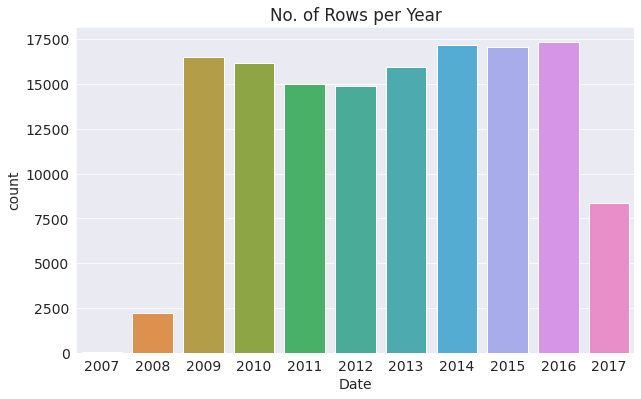

In [23]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(raw_df.Date).dt.year);

In [24]:
year = pd.to_datetime(raw_df.Date).dt.year

train_df = raw_df[year < 2015]
val_df = raw_df[year == 2015]
test_df = raw_df[year > 2015]

In [25]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (97988, 23)
val_df.shape : (17089, 23)
test_df.shape : (25710, 23)


While not a perfect 60-20-20 split, we have ensured that the test validation and test sets both contain data for all 12 months of the year.

In [26]:
train_df

Date Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
0       2008-12-01   Albury     13.4  ...     21.8         No            No
1       2008-12-02   Albury      7.4  ...     24.3         No            No
2       2008-12-03   Albury     12.9  ...     23.2         No            No
3       2008-12-04   Albury      9.2  ...     26.5         No            No
4       2008-12-05   Albury     17.5  ...     29.7         No            No
...            ...      ...      ...  ...      ...        ...           ...
144548  2014-12-27    Uluru     16.9  ...     31.8         No            No
144549  2014-12-28    Uluru     15.1  ...     34.8         No            No
144550  2014-12-29    Uluru     17.3  ...     35.7         No            No
144551  2014-12-30    Uluru     20.1  ...     37.2         No            No
144552  2014-12-31    Uluru     22.5  ...     37.4         No            No

[97988 rows x 23 columns]

In [27]:
val_df

Date Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
2133    2015-01-01   Albury     11.4  ...     32.7         No            No
2134    2015-01-02   Albury     15.5  ...     38.2         No            No
2135    2015-01-03   Albury     17.1  ...     37.0         No            No
2136    2015-01-04   Albury     26.0  ...     30.9         No            No
2137    2015-01-05   Albury     19.0  ...     32.5         No            No
...            ...      ...      ...  ...      ...        ...           ...
144913  2015-12-27    Uluru     20.5  ...     33.0         No            No
144914  2015-12-28    Uluru     18.0  ...     35.0         No            No
144915  2015-12-29    Uluru     17.5  ...     34.7         No            No
144916  2015-12-30    Uluru     20.0  ...     38.4         No            No
144917  2015-12-31    Uluru     19.3  ...     35.8         No            No

[17089 rows x 23 columns]

In [28]:
test_df

Date Location  MinTemp  ...  Temp3pm  RainToday  RainTomorrow
2498    2016-01-01   Albury     20.4  ...     36.7         No            No
2499    2016-01-02   Albury     20.9  ...     31.7         No           Yes
2500    2016-01-03   Albury     18.4  ...     19.5        Yes           Yes
2501    2016-01-04   Albury     17.3  ...     21.6        Yes           Yes
2502    2016-01-05   Albury     15.5  ...     22.2        Yes            No
...            ...      ...      ...  ...      ...        ...           ...
145454  2017-06-20    Uluru      3.5  ...     20.9         No            No
145455  2017-06-21    Uluru      2.8  ...     22.4         No            No
145456  2017-06-22    Uluru      3.6  ...     24.5         No            No
145457  2017-06-23    Uluru      5.4  ...     26.1         No            No
145458  2017-06-24    Uluru      7.8  ...     26.0         No            No

[25710 rows x 23 columns]

## Identifying Input and Target Columns

Often, not all the columns in a dataset are useful for training a model. In the current dataset, we can ignore the `Date` column, since we only want to weather conditions to make a prediction about whether it will rain the next day.

Let's create a list of input columns, and also identify the target column.

In [29]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

In [30]:
print(input_cols)

['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday']


In [31]:
target_col

'RainTomorrow'

We can now create inputs and targets for the training, validation and test sets for further processing and model training.

In [32]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [33]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [34]:
test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

In [35]:
train_inputs

Location  MinTemp  MaxTemp  ...  Temp9am  Temp3pm  RainToday
0        Albury     13.4     22.9  ...     16.9     21.8         No
1        Albury      7.4     25.1  ...     17.2     24.3         No
2        Albury     12.9     25.7  ...     21.0     23.2         No
3        Albury      9.2     28.0  ...     18.1     26.5         No
4        Albury     17.5     32.3  ...     17.8     29.7         No
...         ...      ...      ...  ...      ...      ...        ...
144548    Uluru     16.9     33.2  ...     23.7     31.8         No
144549    Uluru     15.1     36.8  ...     28.9     34.8         No
144550    Uluru     17.3     37.8  ...     29.7     35.7         No
144551    Uluru     20.1     38.5  ...     29.8     37.2         No
144552    Uluru     22.5     39.6  ...     30.1     37.4         No

[97988 rows x 21 columns]

In [36]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

Let's also identify which of the columns are numerical and which ones are categorical. This will be useful later, as we'll need to convert the categorical data to numbers for training a logistic regression model.

In [37]:
!pip install numpy --quiet

In [38]:
import numpy as np

In [39]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

In [40]:
train_inputs[numeric_cols].describe()

MinTemp       MaxTemp  ...      Cloud3pm       Temp9am
count  97674.000000  97801.000000  ...  61966.000000  97414.000000
mean      12.007831     23.022202  ...      4.410677     16.835126
std        6.347175      6.984397  ...      2.693370      6.404586
min       -8.500000     -4.100000  ...      0.000000     -5.900000
25%        7.500000     17.900000  ...      2.000000     12.200000
50%       11.800000     22.400000  ...      5.000000     16.600000
75%       16.600000     27.900000  ...      7.000000     21.400000
max       33.900000     48.100000  ...      9.000000     40.200000

[8 rows x 15 columns]

Let's also check the number of categories in each of the categorical columns.

In [41]:
train_inputs[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

## Imputing Missing Numeric Data

Machine learning models can't work with missing numerical data. The process of filling missing values is called imputation.

There are several techniques for imputation, but I'll use the most basic one: replacing missing values with the average value in the column using the `SimpleImputer` class from `sklearn.impute`.

In [42]:
from sklearn.impute import SimpleImputer

In [43]:
imputer = SimpleImputer(strategy = 'mean')

Before we perform imputation, let's check the no. of missing values in each numeric column.

In [44]:
raw_df[numeric_cols].isna().sum()

MinTemp            468
MaxTemp            307
Rainfall             0
Evaporation      59694
Sunshine         66805
WindGustSpeed     9105
WindSpeed9am      1055
WindSpeed3pm      2531
Humidity9am       1517
Humidity3pm       3501
Pressure9am      13743
Pressure3pm      13769
Cloud9am         52625
Cloud3pm         56094
Temp9am            656
dtype: int64

These values are spread across the training, test and validation sets. You can also check the no. of missing values individually for `train_inputs`, `val_inputs` and `test_inputs`.

In [45]:
train_inputs[numeric_cols].isna().sum()

MinTemp            314
MaxTemp            187
Rainfall             0
Evaporation      36331
Sunshine         40046
WindGustSpeed     6828
WindSpeed9am       874
WindSpeed3pm      1069
Humidity9am       1052
Humidity3pm       1116
Pressure9am       9112
Pressure3pm       9131
Cloud9am         34988
Cloud3pm         36022
Temp9am            574
dtype: int64

The first step in imputation is to `fit` the 


imputer to the data i.e. compute the chosen statistic (e.g. mean) for each column in the dataset. 

In [46]:
imputer.fit(raw_df[numeric_cols])

SimpleImputer()

The missing values in the training, test and validation sets can now be filled in using the transform method of imputer.

In [47]:
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

In [48]:
train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
dtype: int64

Another good practice is to scale numeric features to a small range of values e.g. $(0,1)$ or $(-1,1)$. Scaling numeric features ensures that no particular feature has a disproportionate impact on the model's loss. Optimization algorithms also work better in practice with smaller numbers.


Let's use `MinMaxScaler` from `sklearn.preprocessing` to scale values to the $(0,1)$ range.


In [50]:
from sklearn.preprocessing import MinMaxScaler

In [51]:
scaler = MinMaxScaler()

In [52]:
scaler.fit(raw_df[numeric_cols])

MinMaxScaler()

We can now separately scale the training, validation and test sets using the `transform` method of `scaler`.

In [53]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [54]:
train_inputs[numeric_cols].describe()

MinTemp       MaxTemp  ...      Cloud3pm       Temp9am
count  97988.000000  97988.000000  ...  97988.000000  97988.000000
mean       0.483689      0.525947  ...      0.493693      0.507089
std        0.149458      0.131904  ...      0.238028      0.134722
min        0.000000      0.013233  ...      0.000000      0.027426
25%        0.377358      0.429112  ...      0.333333      0.409283
50%        0.478774      0.514178  ...      0.499917      0.502110
75%        0.591981      0.618147  ...      0.666667      0.601266
max        1.000000      1.000000  ...      1.000000      1.000000

[8 rows x 15 columns]

## Encoding Categorical Data

Since machine learning models can only be trained with numeric data, we need to convert categorical data to numbers. A common technique is to use one-hot encoding for categorical columns.

One hot encoding involves adding a new binary (0/1) column for each unique category of a categorical column.

In [55]:
raw_df[categorical_cols].nunique()

Location       49
WindGustDir    16
WindDir9am     16
WindDir3pm     16
RainToday       2
dtype: int64

In [56]:
from sklearn.preprocessing import OneHotEncoder

In [57]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

In [58]:
encoder.fit(raw_df[categorical_cols])

OneHotEncoder(handle_unknown='ignore', sparse=False)

The encoder has created a list of categories for each of the categorical columns in the dataset. 

We can generate column names for each individual category using `get_feature_names`.

In [59]:
encoded_cols = list(encoder.get_feature_names(categorical_cols))
print(encoded_cols)

['Location_Adelaide', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAAF', 'Location_Penrith', 'Location_Perth', 'Location_PerthAirport', 'Location_Portland', 'Location_Richmond', 'Location_Sale', 'Location_SalmonGums', 'Location_Sydney', 'Location_SydneyAirport', 'Location_Townsville', 'Location_Tuggeranong', 'Location_Uluru', 'Location_WaggaWagga', 'Location_Walpole', 'Location_Watsonia', 'Location_Williamtown', 'Loca

In [60]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

In [61]:
pd.set_option('display.max_columns', None)

In [62]:
test_inputs

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  \
2498     Albury  0.681604  0.801512  0.000000     0.037741  0.526244   
2499     Albury  0.693396  0.725898  0.001078     0.037741  0.526244   
2500     Albury  0.634434  0.527410  0.005930     0.037741  0.526244   
2501     Albury  0.608491  0.538752  0.042049     0.037741  0.526244   
2502     Albury  0.566038  0.523629  0.018329     0.037741  0.526244   
...         ...       ...       ...       ...          ...       ...   
145454    Uluru  0.283019  0.502836  0.000000     0.037741  0.526244   
145455    Uluru  0.266509  0.533081  0.000000     0.037741  0.526244   
145456    Uluru  0.285377  0.568998  0.000000     0.037741  0.526244   
145457    Uluru  0.327830  0.599244  0.000000     0.037741  0.526244   
145458    Uluru  0.384434  0.601134  0.000000     0.037741  0.526244   

       WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
2498           ENE       0.372093        NaN        ESE      0.000000   
2499           SSE       0.341085        SSE         SE      0.069231   
2500           ENE       0.325581        ESE        ENE      0.084615   
2501           SSE       0.255814         SE        SSE      0.069231   
2502           ENE       0.193798         SE        SSE      0.046154   
...            ...            ...        ...        ...           ...   
145454           E       0.193798        ESE          E      0.115385   
145455           E       0.193798         SE        ENE      0.100000   
145456         NNW       0.124031         SE          N      0.100000   
145457           N       0.240310         SE        WNW      0.069231   
145458          SE       0.170543        SSE          N      0.100000   

        WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  \
2498        0.080460         0.46         0.17     0.543802       0.5136   
2499        0.195402         0.54         0.30     0.505785       0.5008   
2500        0.448276         0.62         0.67     0.553719       0.6032   
2501        0.195402         0.74         0.65     0.618182       0.6304   
2502        0.103448         0.92         0.63     0.591736       0.5888   
...              ...          ...          ...          ...          ...   
145454      0.149425         0.59         0.27     0.730579       0.7056   
145455      0.126437         0.51         0.24     0.728926       0.6912   
145456      0.103448         0.56         0.21     0.710744       0.6720   
145457      0.103448         0.53         0.24     0.669421       0.6352   
145458      0.080460         0.51         0.24     0.642975       0.6304   

        Cloud9am  Cloud3pm   Temp9am  Temp3pm RainToday  Location_Adelaide  \
2498    0.777778  0.333333  0.702532     36.7        No                0.0   
2499    0.888889  0.888889  0.675105     31.7        No                0.0   
2500    0.888889  0.888889  0.611814     19.5       Yes                0.0   
2501    0.888889  0.888889  0.556962     21.6       Yes                0.0   
2502    0.888889  0.888889  0.514768     22.2       Yes                0.0   
...          ...       ...       ...      ...       ...                ...   
145454  0.492351  0.499917  0.350211     20.9        No                0.0   
145455  0.492351  0.499917  0.364979     22.4        No                0.0   
145456  0.492351  0.499917  0.381857     24.5        No                0.0   
145457  0.492351  0.499917  0.415612     26.1        No                0.0   
145458  0.333333  0.222222  0.470464     26.0        No                0.0   

        Location_Albany  Location_Albury  Location_AliceSprings  \
2498                0.0              1.0                    0.0   
2499                0.0              1.0                    0.0   
2500                0.0              1.0                    0.0   
2501                0.0              1.0                    0.0   
2502                0.0              1.0                    0.0   
...          

## Training a Logistic Regression Model

Logistic regression is a commonly used technique for solving binary classification problems. In a logistic regression model: 

- we take linear combination (or weighted sum of the input features) 
- we apply the sigmoid function to the result to obtain a number between 0 and 1
- this number represents the probability of the input being classified as "Yes"
- instead of RMSE, the cross entropy loss function is used to evaluate the results

To train a logistic regression model, we can use the `LogisticRegression` class from Scikit-learn.

In [63]:
from sklearn.linear_model import LogisticRegression

In [64]:
model = LogisticRegression(solver='liblinear')

In [65]:
model.fit(train_inputs[numeric_cols + encoded_cols], train_targets)

LogisticRegression(solver='liblinear')

## Making Predictions and Evaluating the Model

We can now use the trained model to make predictions on the training, test 

In [66]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

In [67]:
train_preds = model.predict(X_train)

In [68]:
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [69]:
train_targets

0         No
1         No
2         No
3         No
4         No
          ..
144548    No
144549    No
144550    No
144551    No
144552    No
Name: RainTomorrow, Length: 97988, dtype: object

We can output a probabilistic prediction using `predict_proba`.

In [70]:
train_probs = model.predict_proba(X_train)
train_probs

array([[0.93950704, 0.06049296],
       [0.94333134, 0.05666866],
       [0.95980416, 0.04019584],
       ...,
       [0.98729985, 0.01270015],
       [0.98358003, 0.01641997],
       [0.87598858, 0.12401142]])

The numbers above indicate the probabilities for the target classes "No" and "Yes".

In [71]:
model.classes_

array(['No', 'Yes'], dtype=object)

We can test the accuracy of the model's predictions by computing the percentage of matching values in train_preds and train_targets.

This can be done using the accuracy_score function from sklearn.metrics

In [72]:
from sklearn.metrics import accuracy_score
accuracy_score(train_targets, train_preds)

0.8519002326815528

In [73]:
from sklearn.metrics import confusion_matrix
confusion_matrix(train_targets, train_preds, normalize='true')

array([[0.94613466, 0.05386534],
       [0.477475  , 0.522525  ]])

I'll define a function to generate predictions, compute the accuracy score and plot a confusion matrix for a given st of inputs.

In [74]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name));
    
    return preds

Accuracy: 85.19%


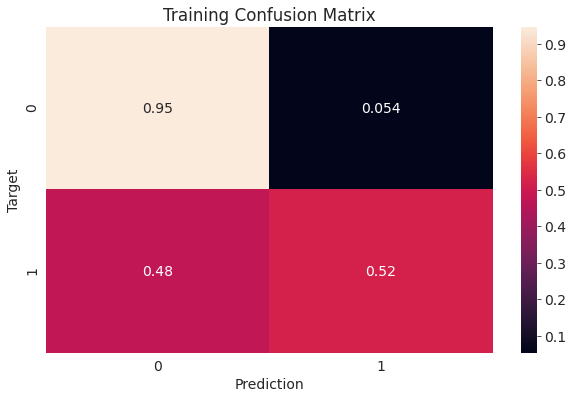

In [75]:
train_preds = predict_and_plot(X_train, train_targets, 'Training')


Let's compute the model's accuracy on the validation and test sets too.

Accuracy: 85.41%


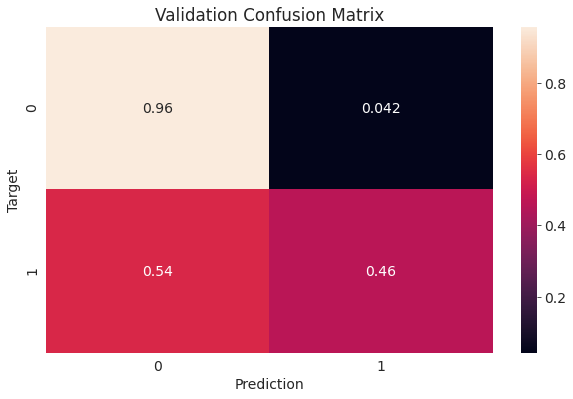

In [76]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')

Accuracy: 84.25%


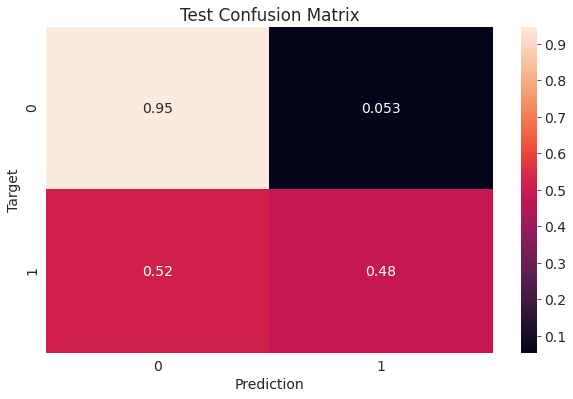

In [77]:
test_preds = predict_and_plot(X_test, test_targets, 'Test')

## Making Predictions on a Single Input

Once the model has been trained to a satisfactory accuracy, it can be used to make predictions on new data. Consider the following dictionary containing data collected from the Katherine weather department today.

In [79]:
new_input = {'Date': '2021-06-19',
             'Location': 'Katherine',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

The first step is to convert the dictionary into a Pandas dataframe, similar to `raw_df`. This can be done by passing a list containing the given dictionary to the `pd.DataFrame` constructor.

In [80]:
new_input_df = pd.DataFrame([new_input])

In [81]:
new_input_df

Date   Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2021-06-19  Katherine     23.2     33.2      10.2          4.2       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  WindSpeed9am  \
0         NNW           52.0         NW        NNE          13.0   

   WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  \
0          20.0         89.0         58.0       1004.8       1001.5       8.0   

   Cloud3pm  Temp9am  Temp3pm RainToday  
0       5.0     25.7     33.0       Yes

The dataframe contains just one row of data, containing the given input.


We must now apply the same transformations applied while training the model:

1. Imputation of missing values using the `imputer` created earlier
2. Scaling numerical features using the `scaler` created earlier
3. Encoding categorical features using the `encoder` created earlier

In [82]:
new_input_df[numeric_cols] = imputer.transform(new_input_df[numeric_cols])
new_input_df[numeric_cols] = scaler.transform(new_input_df[numeric_cols])
new_input_df[encoded_cols] = encoder.transform(new_input_df[categorical_cols])

In [83]:
X_new_input = new_input_df[numeric_cols + encoded_cols]
X_new_input

MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0  0.747642  0.718336  0.027493     0.028966  0.526244       0.356589   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  Pressure9am  \
0           0.1      0.229885         0.89         0.58     0.401653   

   Pressure3pm  Cloud9am  Cloud3pm   Temp9am  Location_Adelaide  \
0       0.3904  0.888889  0.555556  0.694093                0.0   

   Location_Albany  Location_Albury  Location_AliceSprings  \
0              0.0              0.0                    0.0   

   Location_BadgerysCreek  Location_Ballarat  Location_Bendigo  \
0                     0.0                0.0               0.0   

   Location_Brisbane  Location_Cairns  Location_Canberra  Location_Cobar  \
0                0.0              0.0                0.0             0.0   

   Location_CoffsHarbour  Location_Dartmoor  Location_Darwin  \
0                    0.0                0.0              0.0   

   Location_GoldCoast  Location_Hobart  Location_Katherine  \
0                 0.0              0.0                 1.0   

   Location_Launceston  Location_Melbourne  Location_MelbourneAirport  \
0                  0.0                 0.0                        0.0   

   Location_Mildura  Location_Moree  Location_MountGambier  \
0               0.0             0.0                    0.0   

   Location_MountGinini  Location_Newcastle  Location_Nhil  \
0                   0.0                 0.0            0.0   

   Location_NorahHead  Location_NorfolkIsland  Location_Nuriootpa  \
0                 0.0                     0.0                 0.0   

   Location_PearceRAAF  Location_Penrith  Location_Perth  \
0                  0.0               0.0             0.0   

   Location_PerthAirport  Location_Portland  Location_Richmond  Location_Sale  \
0                    0.0                0.0                0.0            0.0   

   Location_SalmonGums  Location_Sydney  Location_SydneyAirport  \
0                  0.0              0.0                     0.0   

   Location_Townsville  Location_Tuggeranong  Location_Uluru  \
0                  0.0                   0.0             0.0   

   Location_WaggaWagga  Location_Walpole  Location_Watsonia  \
0                  0.0               0.0                0.0   

   Location_Williamtown  Location_Witchcliffe  Location_Wollongong  \
0                   0.0                   0.0                  0.0   

   Location_Woomera  WindGustDir_E  WindGustDir_ENE  WindGustDir_ESE  \
0               0.0            0.0              0.0              0.0   

   WindGustDir_N  WindGustDir_NE  WindGustDir_NNE  WindGustDir_NNW  \
0            0.0             0.0              0.0              1.0   

   WindGustDir_NW  WindGustDir_S  WindGustDir_SE  WindGustDir_SSE  \
0             0.0            0.0             0.0              0.0   

   WindGustDir_SSW  WindGustDir_SW  WindGustDir_W  WindGustDir_WNW  \
0              0.0             0.0            0.0              0.0   

   WindGustDir_WSW  WindGustDir_nan  WindDir9am_E  WindDir9am_ENE  \
0              0.0              0.0           0.0             0.0   

   WindDir9am_ESE  WindDir9am_N  WindDir9am_NE  WindDir9am_NNE  \
0             0.0           0.0            0.0             0.0   

   WindDir9am_NNW  WindDir9am_NW  WindDir9am_S  WindDir9am_SE  WindDir9am_SSE  \
0             0.0            1.0           0.0            0.0             0.0   

   WindDir9am_SSW  WindDir9am_SW  WindDir9am_W  WindDir9am_WNW  \
0             0.0            0.0           0.0             0.0   

   WindDir9am_WSW  WindDir9am_nan  WindDir3pm_E  WindDir3pm_ENE  \
0             0.0             0.0           0.0             0.0   

   WindDir3pm_ESE  WindDir3pm_N  WindDir3pm_NE  WindDir3pm_NNE  \
0             0.0           0.0            0.0             1.0   

   WindDir3pm_NNW  WindDir3pm_NW  WindDir3pm_S  WindDir3pm_SE  WindDir3pm_SSE  \
0             0.0            0.0           0.0            0.0             0.0

We can now make a prediction using `model.predict`.

In [84]:
prediction = model.predict(X_new_input)[0]

In [85]:
prediction

'Yes'

Let's define a helper function to make predictions for individual inputs.

In [86]:
def predict_input(single_input):
    input_df = pd.DataFrame([single_input])
    input_df[numeric_cols] = imputer.transform(input_df[numeric_cols])
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    pred = model.predict(X_input)[0]
    prob = model.predict_proba(X_input)[0][list(model.classes_).index(pred)]
    return pred, prob

We can now use this function to make predictions for individual inputs.

In [87]:
new_input = {'Date': '2021-06-19',
             'Location': 'Launceston',
             'MinTemp': 23.2,
             'MaxTemp': 33.2,
             'Rainfall': 10.2,
             'Evaporation': 4.2,
             'Sunshine': np.nan,
             'WindGustDir': 'NNW',
             'WindGustSpeed': 52.0,
             'WindDir9am': 'NW',
             'WindDir3pm': 'NNE',
             'WindSpeed9am': 13.0,
             'WindSpeed3pm': 20.0,
             'Humidity9am': 89.0,
             'Humidity3pm': 58.0,
             'Pressure9am': 1004.8,
             'Pressure3pm': 1001.5,
             'Cloud9am': 8.0,
             'Cloud3pm': 5.0,
             'Temp9am': 25.7,
             'Temp3pm': 33.0,
             'RainToday': 'Yes'}

In [88]:
predict_input(new_input)

('Yes', 0.6316581522137068)

## Saving and Loading Trained Models

We can save the parameters (weights and biases) of our trained model to disk, so that we needn't retrain the model from scratch each time we wish to use it. Along with the model, it's also important to save imputers, scalers, encoders and even column names. Anything that will be required while generating predictions using the model should be saved.

We can use the `joblib` module to save and load Python objects on the disk. 

In [89]:
import joblib

In [90]:
aussie_rain = {
    'model': model,
    'imputer': imputer,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

We can now save this to a file using `joblib.dump`


In [91]:
joblib.dump(aussie_rain, 'aussie_rain.joblib')

['aussie_rain.joblib']

The object can be loaded back using `joblib.load`

In [92]:
aussie_rain2 = joblib.load('aussie_rain.joblib')